Output directory: /home/roberh18/IKT452/Project/outputs/20250428_230213
>>>   Model: efficientnet, Dataset: FER2013   <<<

Calculating mean and std …
Dataset mean:  [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:   [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]

Begin training …
Epoch   1/60 | Train L: 1.4464 A: 0.4974 | Val L: 1.1929 A: 0.6296 | F1: 0.6159 | 84.3s
Epoch   2/60 | Train L: 1.2713 A: 0.5944 | Val L: 1.1604 A: 0.6495 | F1: 0.6359 | 81.5s
Epoch   3/60 | Train L: 1.2106 A: 0.6297 | Val L: 1.1703 A: 0.6581 | F1: 0.6410 | 81.3s
Epoch   4/60 | Train L: 1.1635 A: 0.6514 | Val L: 1.1104 A: 0.6810 | F1: 0.6763 | 81.5s
Epoch   5/60 | Train L: 1.1230 A: 0.6715 | Val L: 1.1173 A: 0.6906 | F1: 0.6849 | 82.0s
Epoch   6/60 | Train L: 1.0901 A: 0.6910 | Val L: 1.0920 A: 0.7042 | F1: 0.7004 | 81.6s
Epoch   7/60 | Train L: 1.0569 A: 0.7115 | Val L: 1.0848 A: 0.7034 | F1: 0.6986 | 81.9s
Epoch   8/60 | Train L: 1.0174 A: 0.7261 | Val L: 1.1166 A: 0.69

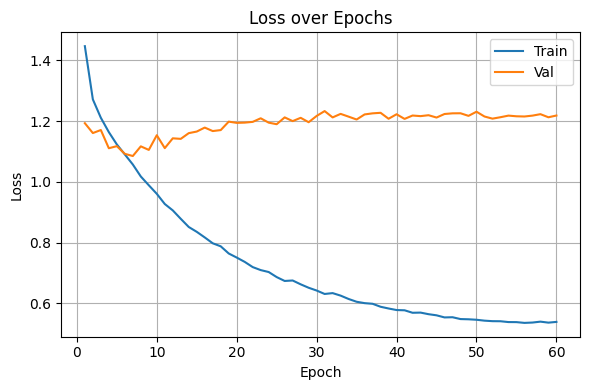

Saved loss plot in /home/roberh18/IKT452/Project/outputs/20250428_230213/loss_epochs.png


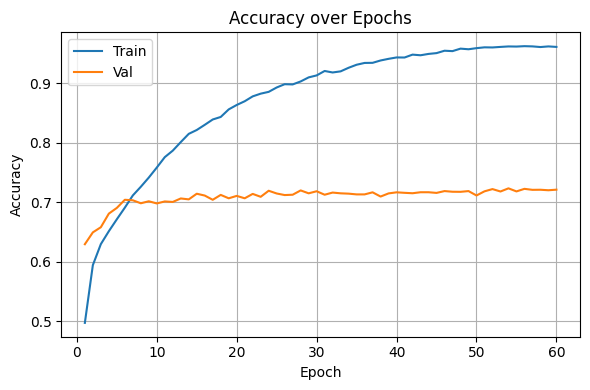

Saved accuracy plot in /home/roberh18/IKT452/Project/outputs/20250428_230213/accuracy_epochs.png

Final evaluation:
Precision: 0.7231, Recall: 0.7235, F1: 0.7227


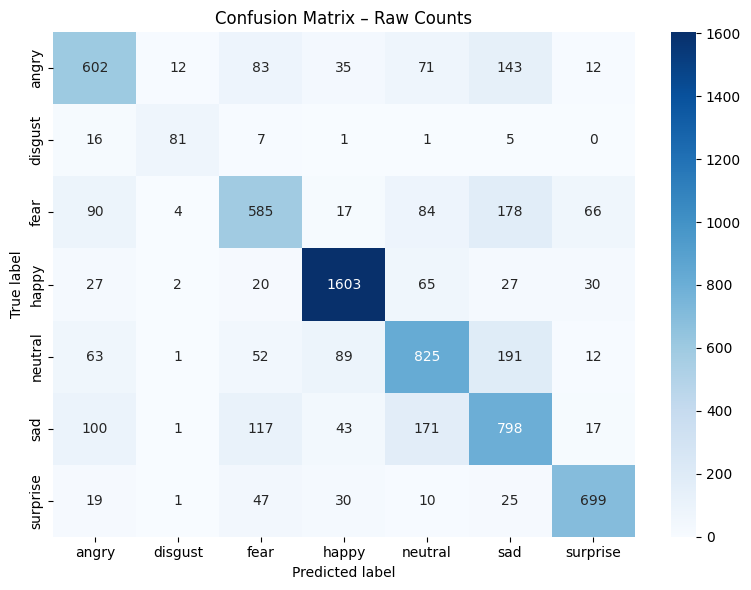

Saved confusion matrix in /home/roberh18/IKT452/Project/outputs/20250428_230213/confusion_matrix.png


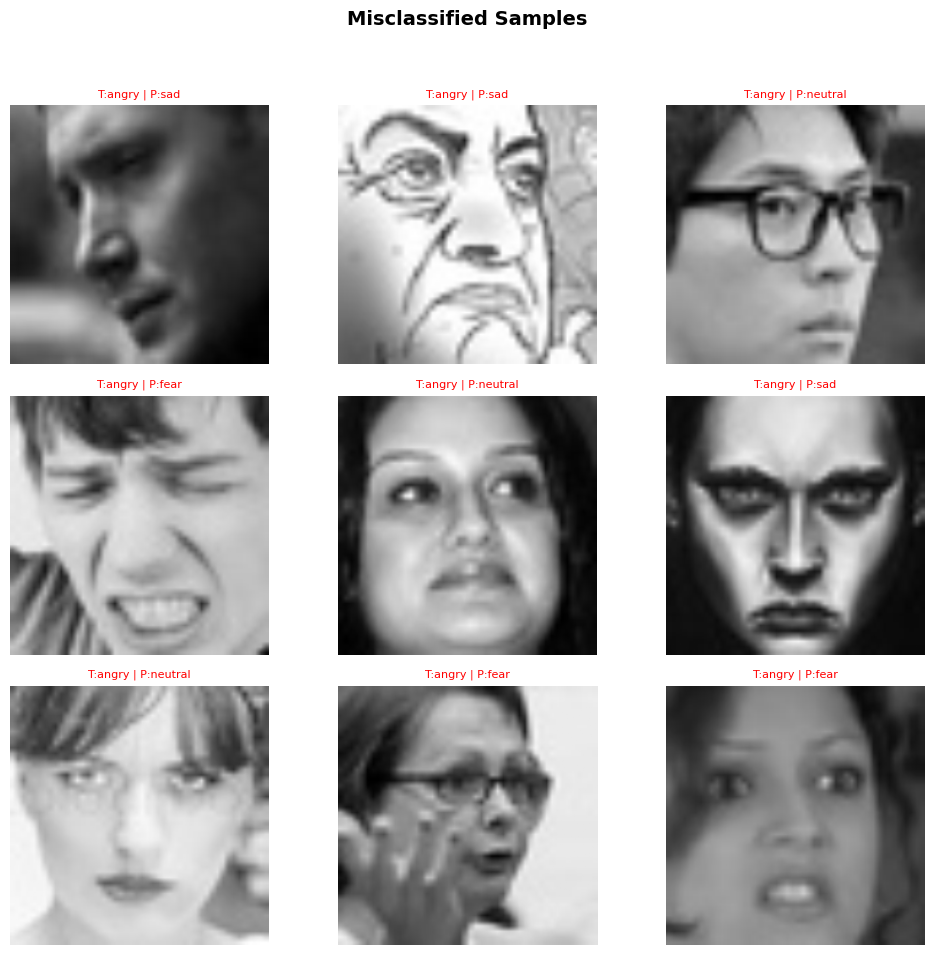

Saved mis‑classified sample grid in /home/roberh18/IKT452/Project/outputs/20250428_230213/misclassified_samples.png


In [1]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configurations and Hyper‑parameters
MODEL_NAME   = "efficientnet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                            
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output folder
try:
    base_dir = Path(__file__).resolve().parent        
except NameError:
    base_dir = Path.cwd()                             

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f">>>   Model: {MODEL_NAME}, Dataset: FER2013   <<<")

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std."""
    print("\nCalculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# Transforms & loaders 
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()


# Plots metrics
epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot in {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot in {acc_path}")

# Final evaluation & Confusion matrix
model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix in {cm_path}")

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid in {fig_path}")

# Show some misclassified samples
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

Output directory: /home/roberh18/IKT452/Project/outputs/20250429_002440
>>>   Model: mobilenet, Dataset: FER2013   <<<

Calculating mean and std …
Dataset mean:  [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:   [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]

Begin training …
Epoch   1/60 | Train L: 1.4757 A: 0.4805 | Val L: 1.2982 A: 0.5793 | F1: 0.5612 | 33.3s
Epoch   2/60 | Train L: 1.3236 A: 0.5676 | Val L: 1.2557 A: 0.6007 | F1: 0.5803 | 32.5s
Epoch   3/60 | Train L: 1.2751 A: 0.5894 | Val L: 1.1986 A: 0.6365 | F1: 0.6331 | 33.1s
Epoch   4/60 | Train L: 1.2404 A: 0.6093 | Val L: 1.1898 A: 0.6510 | F1: 0.6515 | 33.2s
Epoch   5/60 | Train L: 1.2097 A: 0.6251 | Val L: 1.1397 A: 0.6662 | F1: 0.6626 | 31.7s
Epoch   6/60 | Train L: 1.1848 A: 0.6401 | Val L: 1.1676 A: 0.6531 | F1: 0.6479 | 31.2s
Epoch   7/60 | Train L: 1.1686 A: 0.6474 | Val L: 1.1431 A: 0.6682 | F1: 0.6636 | 30.6s
Epoch   8/60 | Train L: 1.1430 A: 0.6605 | Val L: 1.1370 A: 0.6723 

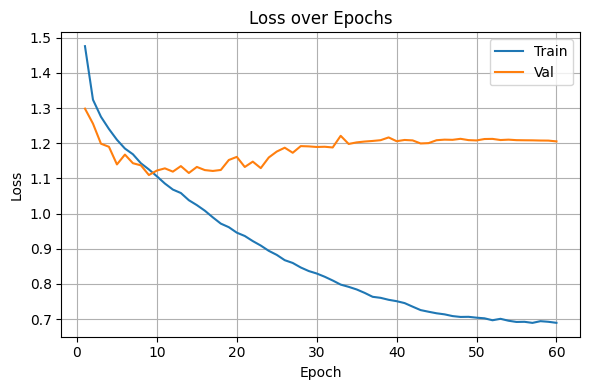

Saved loss plot in /home/roberh18/IKT452/Project/outputs/20250429_002440/loss_epochs.png


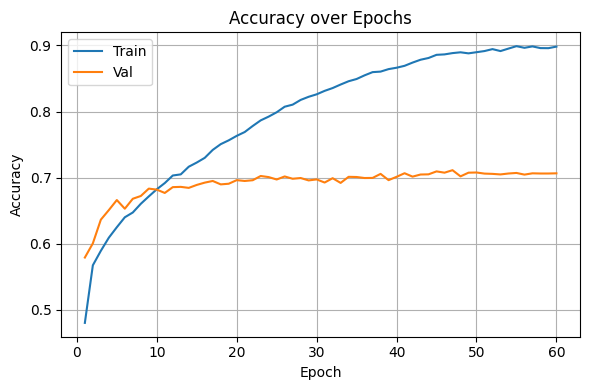

Saved accuracy plot in /home/roberh18/IKT452/Project/outputs/20250429_002440/accuracy_epochs.png

Final evaluation:
Precision: 0.7113, Recall: 0.7113, F1: 0.7107


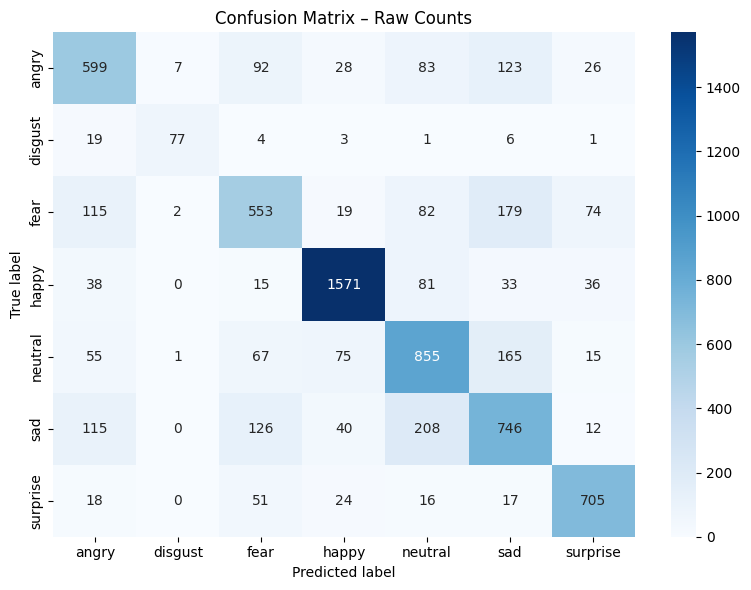

Saved confusion matrix in /home/roberh18/IKT452/Project/outputs/20250429_002440/confusion_matrix.png


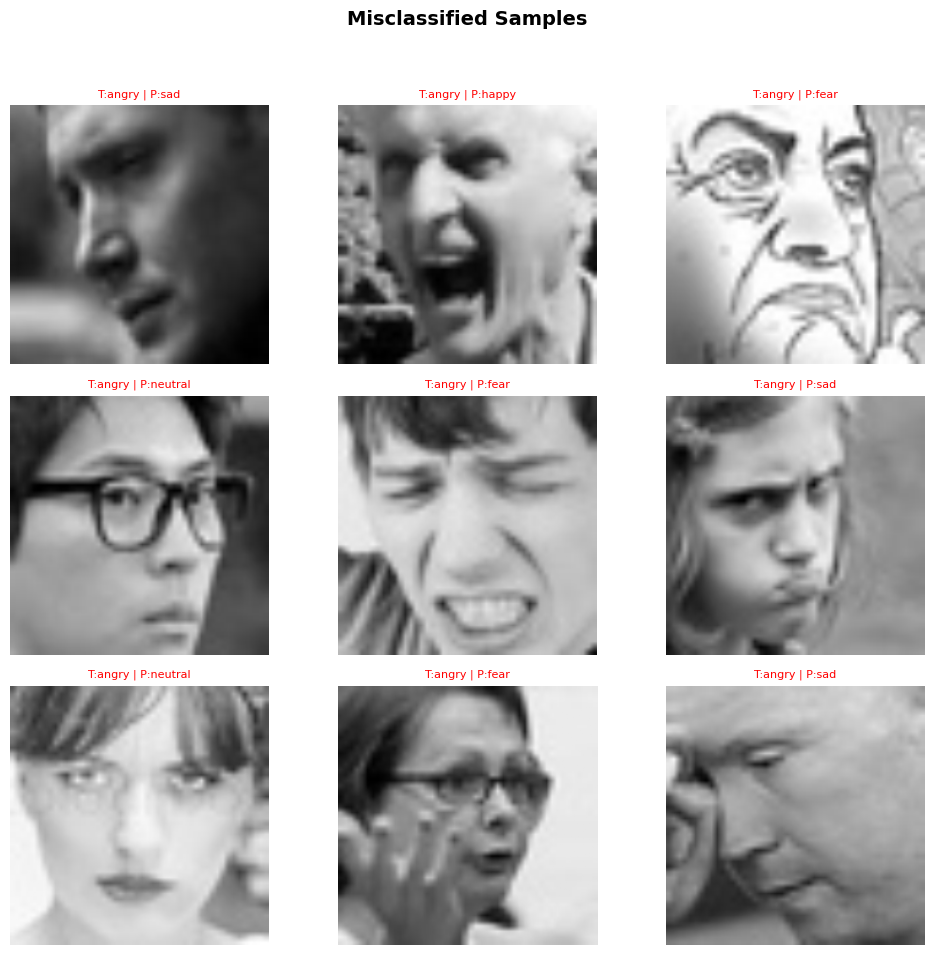

Saved mis‑classified sample grid in /home/roberh18/IKT452/Project/outputs/20250429_002440/misclassified_samples.png


In [2]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configurations and Hyper‑parameters
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                            
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output folder
try:
    base_dir = Path(__file__).resolve().parent       
except NameError:
    base_dir = Path.cwd()                            

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S") 
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f">>>   Model: {MODEL_NAME}, Dataset: FER2013   <<<")

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std."""
    print("\nCalculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# Transforms & loaders 
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()


# Plots metrics
epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot in {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot in {acc_path}")

# Final evaluation & Confusion matrix
model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix in {cm_path}")

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid in {fig_path}")

# Show some misclassified samples
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

Output directory: /home/roberh18/IKT452/Project/outputs/20250429_005654
>>>   Model: efficientnet, Dataset: FERPlus   <<<

Calculating mean and std …
Dataset mean:  [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:   [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]

Begin training …
Epoch   1/60 | Train L: 1.1733 A: 0.6739 | Val L: 0.9060 A: 0.8031 | F1: 0.7878 | 80.5s
Epoch   2/60 | Train L: 0.9869 A: 0.7619 | Val L: 0.8663 A: 0.8149 | F1: 0.8079 | 80.6s
Epoch   3/60 | Train L: 0.9352 A: 0.7825 | Val L: 0.8488 A: 0.8280 | F1: 0.8187 | 81.1s
Epoch   4/60 | Train L: 0.8956 A: 0.8033 | Val L: 0.8453 A: 0.8249 | F1: 0.8227 | 80.7s
Epoch   5/60 | Train L: 0.8671 A: 0.8165 | Val L: 0.8277 A: 0.8372 | F1: 0.8300 | 80.7s
Epoch   6/60 | Train L: 0.8414 A: 0.8277 | Val L: 0.8243 A: 0.8397 | F1: 0.8357 | 80.5s
Epoch   7/60 | Train L: 0.8206 A: 0.8351 | Val L: 0.8229 A: 0.8435 | F1: 0.8393 | 80.5s
Epoch   8/60 | Train L: 0.7966 A: 0.8486 | Val L: 0.8255 A: 0.83

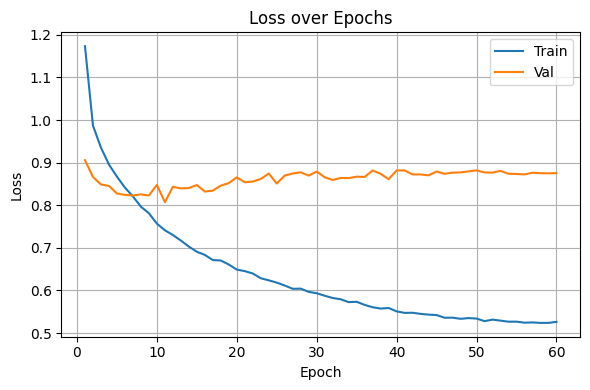

Saved loss plot in /home/roberh18/IKT452/Project/outputs/20250429_005654/loss_epochs.png


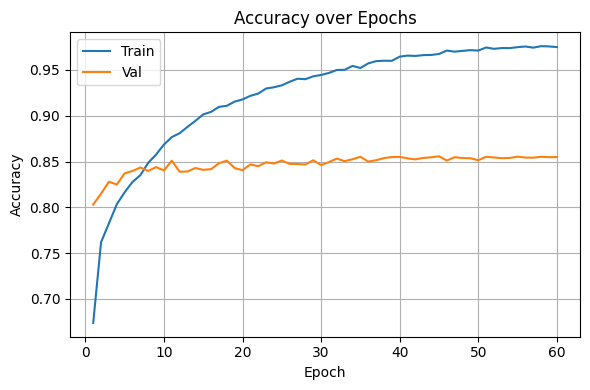

Saved accuracy plot in /home/roberh18/IKT452/Project/outputs/20250429_005654/accuracy_epochs.png

Final evaluation:
Precision: 0.8521, Recall: 0.8551, F1: 0.8521


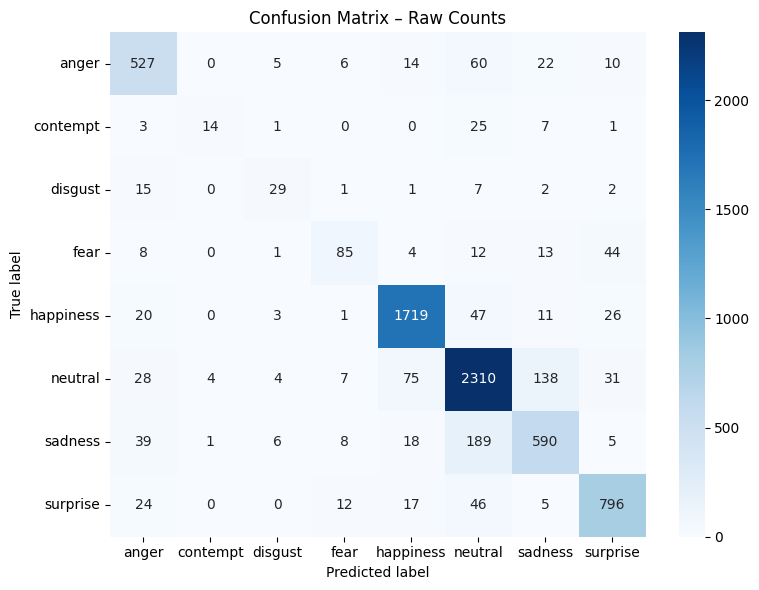

Saved confusion matrix in /home/roberh18/IKT452/Project/outputs/20250429_005654/confusion_matrix.png


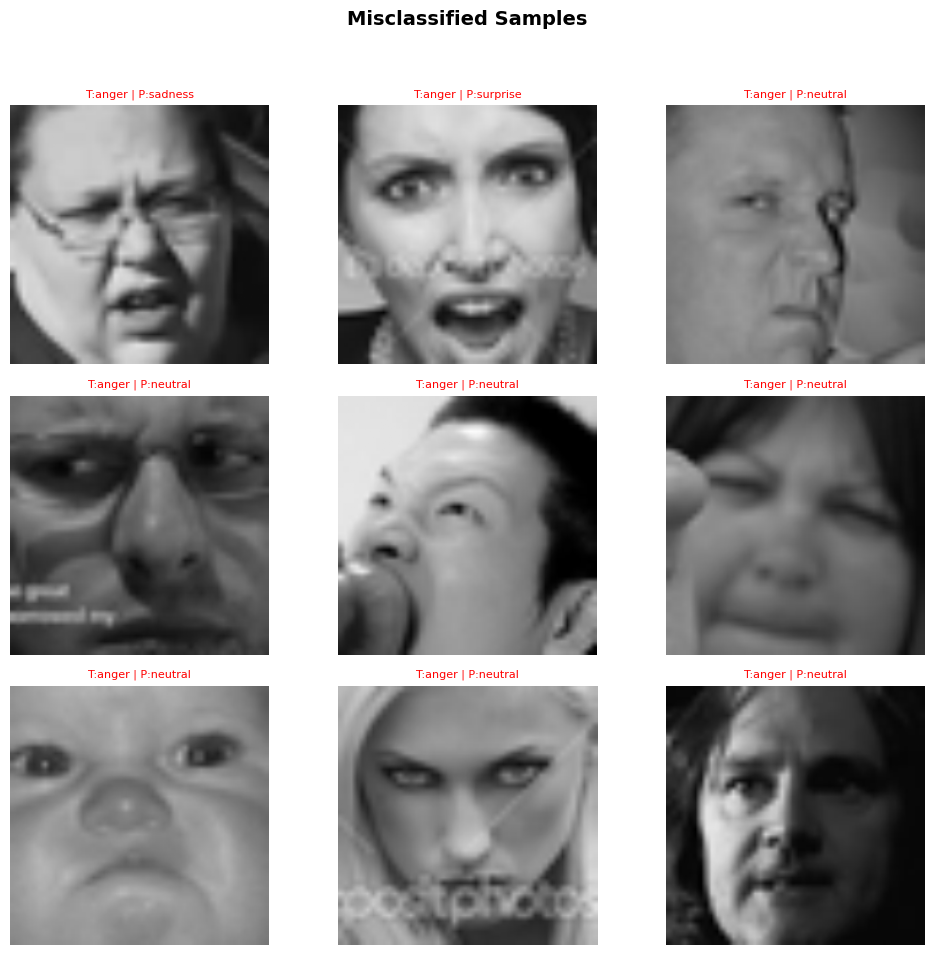

Saved mis‑classified sample grid in /home/roberh18/IKT452/Project/outputs/20250429_005654/misclassified_samples.png


In [3]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configurations and Hyper‑parameters
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "efficientnet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                           
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output folder
try:
    base_dir = Path(__file__).resolve().parent        
except NameError:
    base_dir = Path.cwd()                             

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f">>>   Model: {MODEL_NAME}, Dataset: FERPlus   <<<")

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std."""
    print("\nCalculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# Transforms & loaders 
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()


# Plots metrics
epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot in {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot in {acc_path}")

# Final evaluation & Confusion matrix
model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix in {cm_path}")

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid in {fig_path}")

# Show some misclassified samples
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

Output directory: /home/roberh18/IKT452/Project/outputs/20250429_021825
>>>   Model: mobilenet, Dataset: FERPlus   <<<

Calculating mean and std …
Dataset mean:  [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:   [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]

Begin training …
Epoch   1/60 | Train L: 1.2223 A: 0.6479 | Val L: 1.0048 A: 0.7557 | F1: 0.7471 | 33.7s
Epoch   2/60 | Train L: 1.0536 A: 0.7286 | Val L: 0.9298 A: 0.7880 | F1: 0.7751 | 32.9s
Epoch   3/60 | Train L: 1.0019 A: 0.7529 | Val L: 0.9085 A: 0.8003 | F1: 0.7897 | 31.2s
Epoch   4/60 | Train L: 0.9689 A: 0.7660 | Val L: 0.8950 A: 0.8049 | F1: 0.7885 | 31.0s
Epoch   5/60 | Train L: 0.9424 A: 0.7832 | Val L: 0.8814 A: 0.8065 | F1: 0.8020 | 30.9s
Epoch   6/60 | Train L: 0.9208 A: 0.7912 | Val L: 0.9069 A: 0.7932 | F1: 0.7923 | 30.8s
Epoch   7/60 | Train L: 0.9037 A: 0.7973 | Val L: 0.8542 A: 0.8224 | F1: 0.8145 | 30.8s
Epoch   8/60 | Train L: 0.8819 A: 0.8066 | Val L: 0.9341 A: 0.7862 

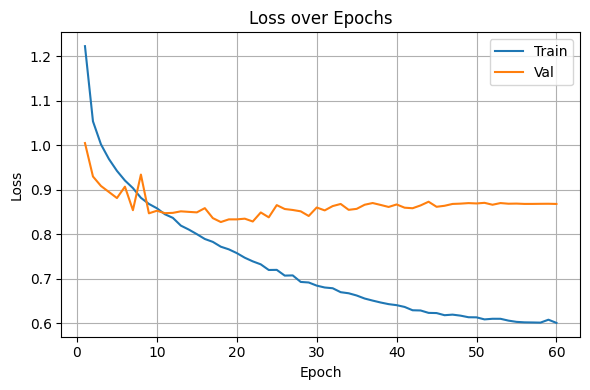

Saved loss plot in /home/roberh18/IKT452/Project/outputs/20250429_021825/loss_epochs.png


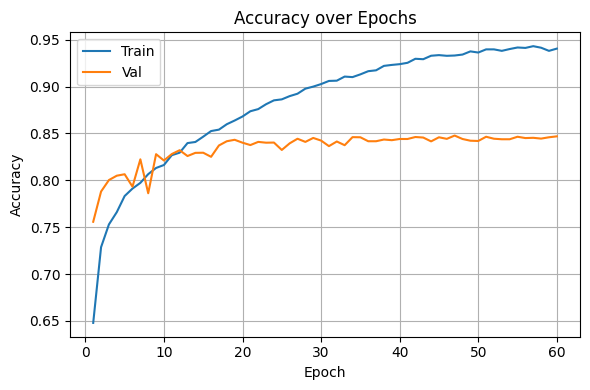

Saved accuracy plot in /home/roberh18/IKT452/Project/outputs/20250429_021825/accuracy_epochs.png

Final evaluation:
Precision: 0.8456, Recall: 0.8477, F1: 0.8452


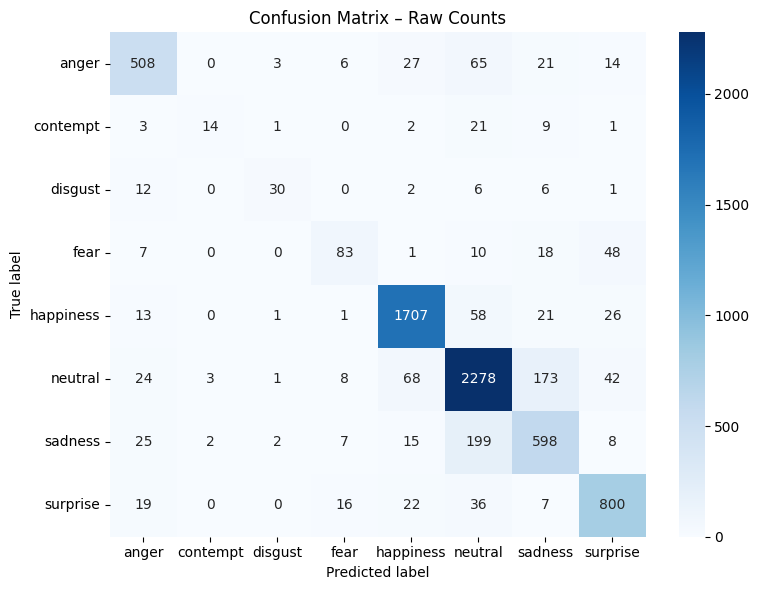

Saved confusion matrix in /home/roberh18/IKT452/Project/outputs/20250429_021825/confusion_matrix.png


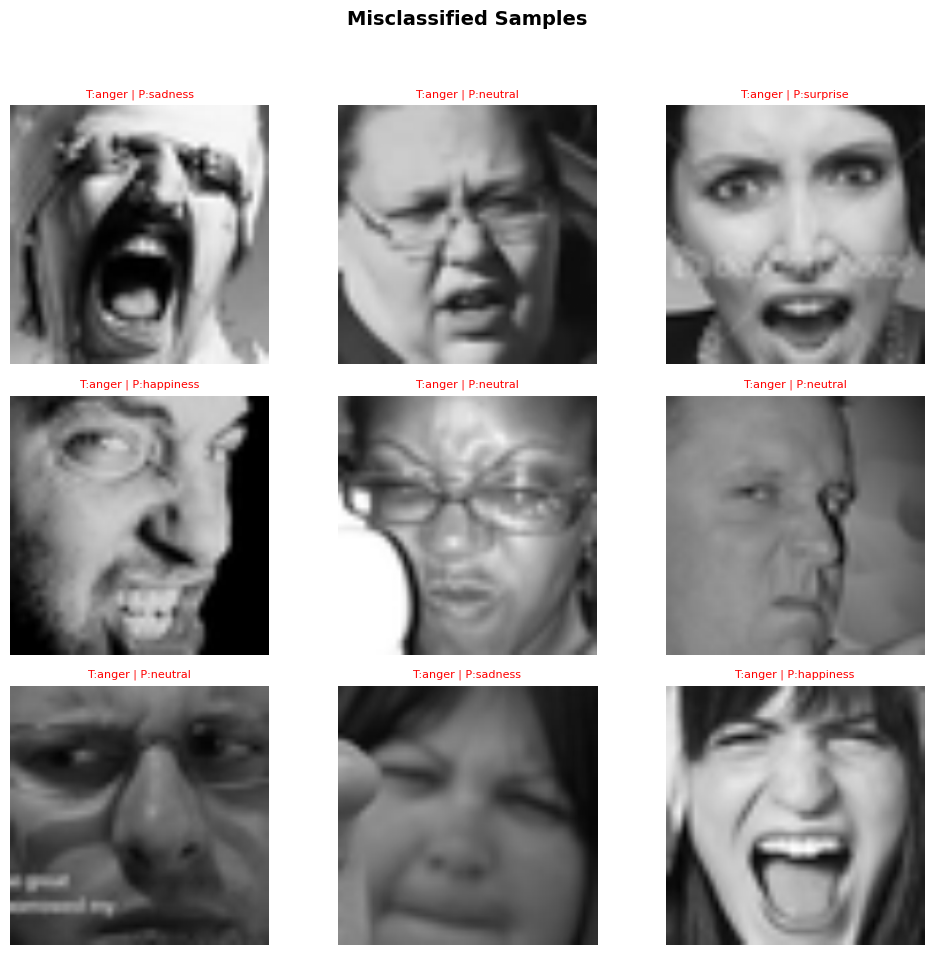

Saved mis‑classified sample grid in /home/roberh18/IKT452/Project/outputs/20250429_021825/misclassified_samples.png


In [4]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# Configurations and Hyper‑parameters
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                             
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Output folder
try:
    base_dir = Path(__file__).resolve().parent       
except NameError:
    base_dir = Path.cwd()                            

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f">>>   Model: {MODEL_NAME}, Dataset: FERPlus   <<<")

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std."""
    print("\nCalculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# Transforms & loaders 
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()


# Plots metrics
epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot in {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot in {acc_path}")

# Final evaluation & Confusion matrix
model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix in {cm_path}")

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid in {fig_path}")

# Show some misclassified samples
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)